In [247]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import  CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

#===== cleaning text
import string 
import re
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from nltk.stem import  PorterStemmer, WordNetLemmatizer
ps = PorterStemmer()
wn = WordNetLemmatizer()


# plt.style.use('seaborn')
%matplotlib inline

### Data Exploration and Preprocessing of the UCL Drug Dataset

In [2]:
train = pd.read_csv("drug/drugLibTrain_raw.tsv", delimiter='\t',encoding='utf-8')
test = pd.read_csv("drug/drugLibTest_raw.tsv", delimiter='\t',encoding='utf-8')

In [3]:
drugs = pd.concat((train, test), axis = 0, ignore_index=True)

In [4]:
drugs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4143 entries, 0 to 4142
Data columns (total 9 columns):
Unnamed: 0           4143 non-null int64
urlDrugName          4143 non-null object
rating               4143 non-null int64
effectiveness        4143 non-null object
sideEffects          4143 non-null object
condition            4142 non-null object
benefitsReview       4143 non-null object
sideEffectsReview    4141 non-null object
commentsReview       4135 non-null object
dtypes: int64(2), object(7)
memory usage: 291.4+ KB


In [5]:
drugs.describe()

,Unnamed: 0,rating
count,4143.000000,4143.000000
mean,2081.808834,6.946416
std,1202.018138,2.948868
min,0.000000,1.000000
25%,1041.500000,5.000000
50%,2083.000000,8.000000
75%,3123.500000,9.000000
max,4161.000000,10.000000


In [6]:
drugs.head()

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [7]:
drugs['rating'].value_counts()

10    968
8     748
9     613
7     471
1     420
5     226
6     215
3     195
4     151
2     136
Name: rating, dtype: int64

In [8]:
drugs.isnull().sum()

Unnamed: 0           0
urlDrugName          0
rating               0
effectiveness        0
sideEffects          0
condition            1
benefitsReview       0
sideEffectsReview    2
commentsReview       8
dtype: int64

In [9]:
drugs.isna().sum()

Unnamed: 0           0
urlDrugName          0
rating               0
effectiveness        0
sideEffects          0
condition            1
benefitsReview       0
sideEffectsReview    2
commentsReview       8
dtype: int64

In [10]:
drugs = drugs.dropna()

In [11]:
drugs = drugs.rename(columns={"Unnamed: 0":"ID", "urlDrugName":"drugName"})

In [12]:
drugs.head()

,ID,drugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [13]:
def clean_text(text):
    text = "".join([c for c in text if c not in string.punctuation])
    tokens = re.split('\W+', text)
    text = " ".join([ps.stem(word) for word in tokens if word not in stopwords])
    return str(text)    

In [14]:
col_obj = []
for col in drugs.columns:
    if drugs[col].dtypes == object:
        col_obj.append(col)
        drugs[col] = drugs[col].apply(lambda x: clean_text(x))
print(col_obj)

['drugName', 'effectiveness', 'sideEffects', 'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview']


In [15]:
drugs['reviews'] = drugs[['benefitsReview', 'sideEffectsReview', 'commentsReview']].apply(lambda x: ''.join(x.map(str)), axis=1)

In [16]:
drugs = drugs.drop(["ID",'condition','benefitsReview', 'sideEffectsReview', 'commentsReview'], axis = 1)

In [308]:
# vec = TfidfVectorizer(min_df=1, max_features=100, stop_words='english')
vec = CountVectorizer(stop_words="english", max_features=100, min_df=1) 
X_reviews = vec.fit_transform(drugs['reviews'])
X_others = pd.get_dummies(drugs[['effectiveness', 'sideEffects']])
X = np.concatenate((X_others.values, X_reviews.toarray()), axis = 1)
y = np.array(drugs['rating'])

### Implementation of Multinomial Gaussian Discriminant Analysis, Multinomial Naive Bayes and Multiclass Logistic Regression Algorithms from Scratch

In [210]:
class GaussianDiscriminantAnalysis:

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        
        phis = []
        for _class in self.classes:
            phis.append((1/n_samples) * np.count_nonzero(y == _class))
        self.phis = phis
            
        means = []
        for _class in self.classes:
            means.append(np.mean(X[y == _class], axis=0))
        self.means = means
        data_means_diff = np.zeros((n_samples, n_features))
        for i in range(n_samples):
            for idx,_class in enumerate(self.classes):
                if y[i] == _class:
                    data_means_diff[i] = X[i] - self.means[idx]
        
        self.sigma = np.dot(np.transpose(data_means_diff), data_means_diff)/n_samples
        self.sigma += 1e-10
        return
    
    def predict(self, X):
        n_samples, n_features = X.shape
        prob = np.zeros((n_samples,len(self.classes)))
        
        for j in range(len(self.classes)):
            power = np.sum((np.dot(X-self.means[j], np.linalg.pinv(self.sigma)) * (X-self.means[j])), axis = 1)
            prob[:,j] = np.exp(-0.5*power)*self.phis[j]
        
        self.predictions = np.argmax(prob, axis =1)
        return
    
    def accuracy(self, y):
        return np.round(np.mean(self.predictions == y)*100, 2)


In [277]:
class MultinomialNaivesBayes:
    
    def fit(self, X, y, l_smooth=1e-10):
        self.l_smooth = l_smooth
        self.y_classes, y_counts = np.unique(y, return_counts=True)
        self.x_classes = np.array([np.unique(x) for x in X.T])
        self.phi_y = 1.0 * y_counts/y_counts.sum()
        self.phi_x = self.get_phi_x(X, y)
        return self
    
    def get_phi_x(self, X, y):
        m_x = []
        for k in self.y_classes:
            m_x_k = []
            for j in range(len(self.x_classes)):
                m_x_k.append((X[:,j][y==k].reshape(-1,1) == self.x_classes[j]).mean(axis=0))
            m_x.append(m_x_k)
        return m_x
        
    def predict(self, X):
        self._predict = np.apply_along_axis(lambda x: self.probs_cal(x), 1, X)
        return self._predict
    
    def probs_cal(self, x):
        probs = np.array([self.prob_cal(x, y) for y in range(len(self.y_classes))])
        return self.y_classes[np.argmax(probs)]
    
    def prob_cal(self, x, y):
        prob_x_y = 1
        for j in range(len(x)):
            if x[j] in self.x_classes[j]:
                i = list(self.x_classes[j]).index(x[j])
                prob_x_y *= self.phi_x[y][j][i] 
            else:
                prob_x_y *= self.l_smooth
        return prob_x_y * self.phi_y[y]
    
    def accuracy(self, y):
        return np.round(np.mean(self._predict == y)*100, 2)


In [278]:
class MultiClassLogisticRegression:
    
    def __init__(self, learning_rate = 0.001, n_iters = 10000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
    
    def fit(self, X, y):
        self.unique_y = np.unique(y)
        y = self.one_hot(y)
        X = np.insert(X, 0, 1, axis=1)
        n_samples, n_features = X.shape
        self.weights = np.zeros((len(self.unique_y), n_features))
        for _ in range(self.n_iters):
            
            linear_model = np.dot(X, self.weights.T)
            yprediction = self.softmax(linear_model)
            
            #gradient descent
            dw = 1/n_samples * np.dot((yprediction - y).T, X)

            #update
            self.weights -= self.lr * dw
    
    def predict(self, X):
        X = np.insert(X, 0, 1, axis=1)
        linear_model = np.dot(X, self.weights.T)
        yprediction = self.softmax(linear_model)
        self.ypred_cls = np.argmax(yprediction, axis=1)
        self.ypred_cls = np.vectorize(lambda c: self.unique_y[c])(self.ypred_cls)
        return self.ypred_cls
    
    def accuracy(self, y_true):
        return np.round(np.mean(y_true == self.ypred_cls)*100, 2)
            
    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1,1)#
    
    def one_hot(self, y):
        u_y = list(np.unique(y))
        result = np.zeros((len(y), len(u_y)))
        for i in range(len(y)):
            result[i][u_y.index(y[i])] = 1
        return result

In [279]:
gda = GaussianDiscriminantAnalysis()
mnb = MultinomialNaivesBayes()
mlr = MultiClassLogisticRegression()

### Model Implementation on the UCL Drugs Dataset

In [304]:
data_percent = [.10,.30,.60,.99]

def modeller(model, data_percent):
    results = {'acc':[], 'eva':[], 'size':[]}
    for percent in data_percent:
        alpha, beta = (percent, 1-percent)      
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=alpha, test_size=beta, random_state=0)
        model.fit(X_train, y_train)
        model.predict(X_train)
        acc = model.accuracy(y_train)
        model.predict(X_test)
        eva = model.accuracy(y_test)
        results['acc'].append(acc)
        results['eva'].append(eva)
        results['size'].append(X_train.shape[0])
        
        print("Training & Evaluation Size: {} | {}".format(X_train.shape[0], X_test.shape[0]))
        print("Training & Evaluation Accuracy: {}% | {}%".format(acc, eva), "\n")
    return results

def plot(results):
    plt.figure(figsize=(10,7))
    plt.plot(results['size'], results['acc'], 'r--', label = "Training") 
    plt.plot(results['size'], results['eva'], 'g--', label = "Evaluation")
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.legend(loc="upper right")
    plt.grid(False)    
    plt.show()
    

Training & Evaluation Size: 413 | 3719
Training & Evaluation Accuracy: 15.74% | 18.37% 

Training & Evaluation Size: 1239 | 2893
Training & Evaluation Accuracy: 16.95% | 18.18% 

Training & Evaluation Size: 2479 | 1653
Training & Evaluation Accuracy: 16.58% | 16.45% 

Training & Evaluation Size: 4090 | 42
Training & Evaluation Accuracy: 17.11% | 7.14% 



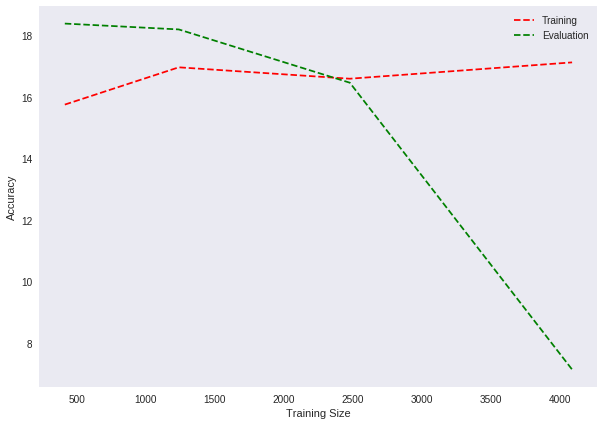

In [295]:
#max 10 features
result_1 = modeller(gda, data_percent)
plot(result_1)

Training & Evaluation Size: 413 | 3719
Training & Evaluation Accuracy: 65.86% | 40.49% 

Training & Evaluation Size: 1239 | 2893
Training & Evaluation Accuracy: 54.24% | 42.93% 

Training & Evaluation Size: 2479 | 1653
Training & Evaluation Accuracy: 51.15% | 45.67% 

Training & Evaluation Size: 4090 | 42
Training & Evaluation Accuracy: 49.9% | 54.76% 



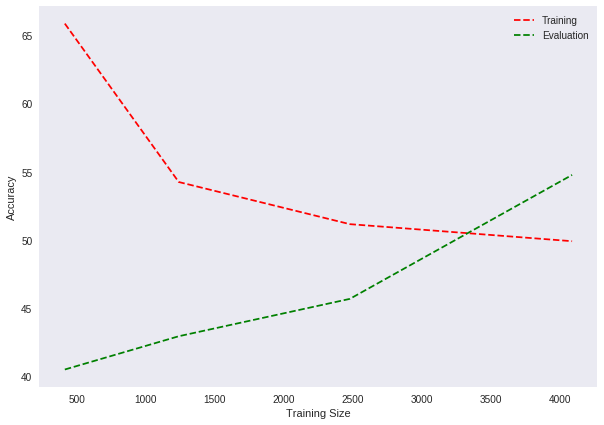

In [296]:
result_2 = modeller(mbn, data_percent)
plot(result_2)

Training & Evaluation Size: 413 | 3719
Training & Evaluation Accuracy: 44.79% | 38.05% 

Training & Evaluation Size: 1239 | 2893
Training & Evaluation Accuracy: 40.19% | 38.51% 

Training & Evaluation Size: 2479 | 1653
Training & Evaluation Accuracy: 39.81% | 39.5% 

Training & Evaluation Size: 4090 | 42
Training & Evaluation Accuracy: 40.34% | 50.0% 



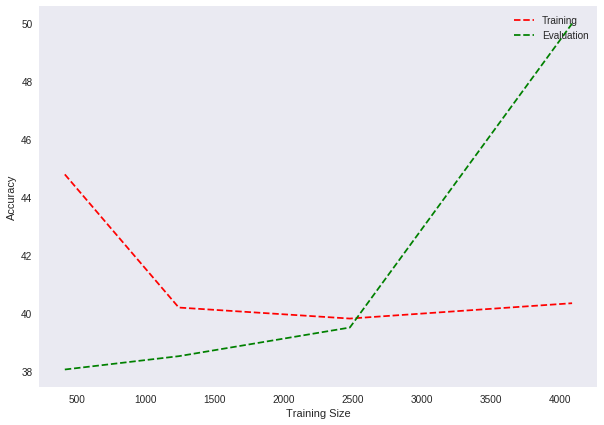

In [297]:
result_3 = modeller(mlr, data_percent)
plot(result_3)

Training & Evaluation Size: 413 | 3719
Training & Evaluation Accuracy: 10.41% | 17.5% 

Training & Evaluation Size: 1239 | 2893
Training & Evaluation Accuracy: 14.93% | 17.73% 

Training & Evaluation Size: 2479 | 1653
Training & Evaluation Accuracy: 15.33% | 16.64% 

Training & Evaluation Size: 4090 | 42
Training & Evaluation Accuracy: 16.48% | 11.9% 



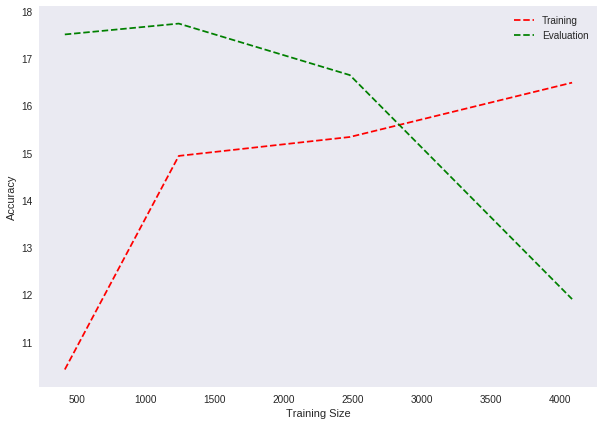

In [300]:
#max features of 50
result_1 = modeller(gda, data_percent)
plot(result_1)

Training & Evaluation Size: 413 | 3719
Training & Evaluation Accuracy: 81.11% | 32.78% 

Training & Evaluation Size: 1239 | 2893
Training & Evaluation Accuracy: 65.38% | 38.75% 

Training & Evaluation Size: 2479 | 1653
Training & Evaluation Accuracy: 60.63% | 40.96% 

Training & Evaluation Size: 4090 | 42
Training & Evaluation Accuracy: 56.82% | 54.76% 



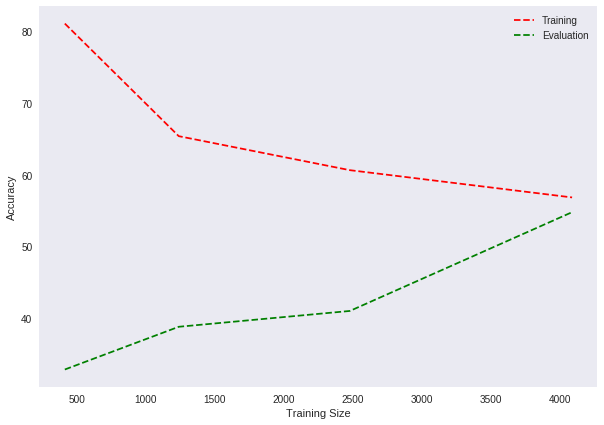

In [301]:
result_2 = modeller(mbn, data_percent)
plot(result_2)

Training & Evaluation Size: 413 | 3719
Training & Evaluation Accuracy: 50.36% | 36.54% 

Training & Evaluation Size: 1239 | 2893
Training & Evaluation Accuracy: 42.21% | 38.47% 

Training & Evaluation Size: 2479 | 1653
Training & Evaluation Accuracy: 40.94% | 39.81% 

Training & Evaluation Size: 4090 | 42
Training & Evaluation Accuracy: 41.1% | 45.24% 



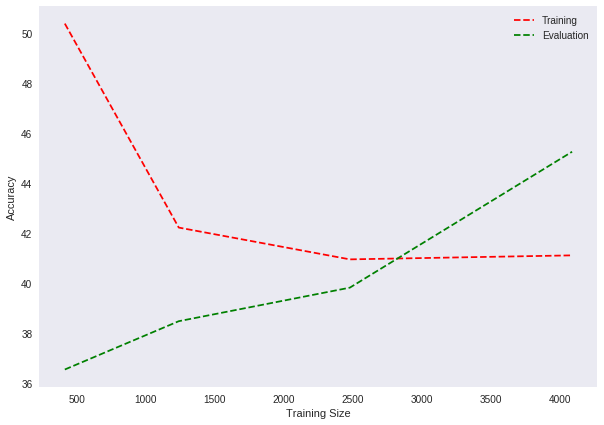

In [302]:
result_3 = modeller(mlr, data_percent)
plot(result_3)

Training & Evaluation Size: 413 | 3719
Training & Evaluation Accuracy: 7.02% | 16.81% 

Training & Evaluation Size: 1239 | 2893
Training & Evaluation Accuracy: 12.51% | 17.21% 

Training & Evaluation Size: 2479 | 1653
Training & Evaluation Accuracy: 13.92% | 17.85% 

Training & Evaluation Size: 4090 | 42
Training & Evaluation Accuracy: 15.16% | 14.29% 



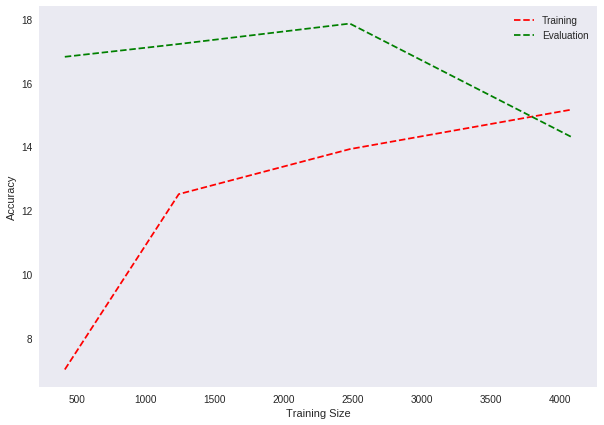

In [305]:
#max features 100
result_1 = modeller(gda, data_percent)
plot(result_1)

Training & Evaluation Size: 413 | 3719
Training & Evaluation Accuracy: 89.35% | 29.23% 

Training & Evaluation Size: 1239 | 2893
Training & Evaluation Accuracy: 72.88% | 37.12% 

Training & Evaluation Size: 2479 | 1653
Training & Evaluation Accuracy: 66.12% | 39.08% 

Training & Evaluation Size: 4090 | 42
Training & Evaluation Accuracy: 60.81% | 40.48% 



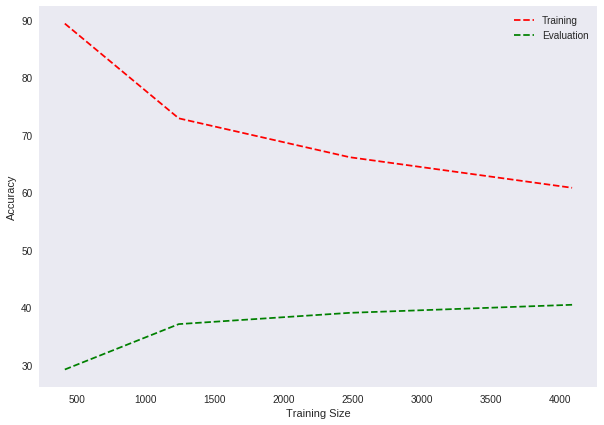

In [306]:
result_2 = modeller(mbn, data_percent)
plot(result_2)

Training & Evaluation Size: 413 | 3719
Training & Evaluation Accuracy: 54.0% | 36.81% 

Training & Evaluation Size: 1239 | 2893
Training & Evaluation Accuracy: 43.42% | 38.96% 

Training & Evaluation Size: 2479 | 1653
Training & Evaluation Accuracy: 41.71% | 39.87% 

Training & Evaluation Size: 4090 | 42
Training & Evaluation Accuracy: 41.39% | 47.62% 



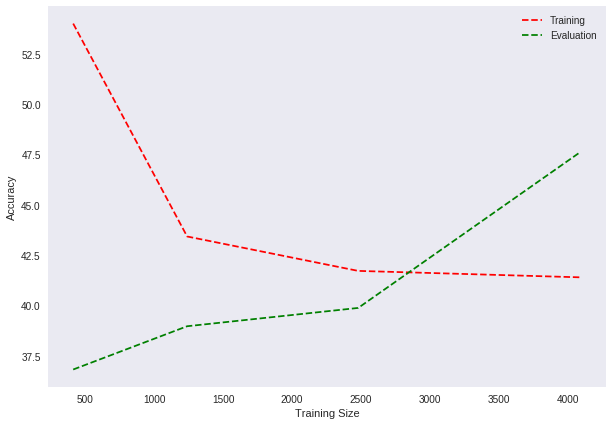

In [307]:
result_3 = modeller(mlr, data_percent)
plot(result_3)

In [ ]:
# Count 500 max_features

Training & Evaluation Size: 413 | 3719
Training & Evaluation Accuracy: 0.0% | 0.13% 

Training & Evaluation Size: 1239 | 2893
Training & Evaluation Accuracy: 3.79% | 11.41% 

Training & Evaluation Size: 2479 | 1653
Training & Evaluation Accuracy: 7.87% | 15.43% 

Training & Evaluation Size: 4090 | 42
Training & Evaluation Accuracy: 10.78% | 23.81% 



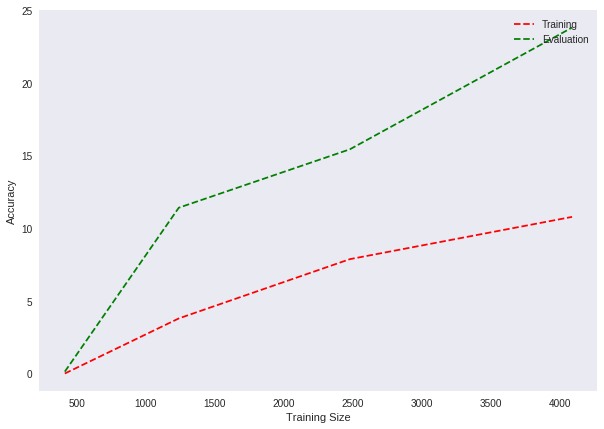

In [309]:
result_1 = modeller(gda, data_percent)
plot(result_1)

Training & Evaluation Size: 413 | 3719
Training & Evaluation Accuracy: 97.34% | 17.1% 

Training & Evaluation Size: 1239 | 2893
Training & Evaluation Accuracy: 90.64% | 27.0% 

Training & Evaluation Size: 2479 | 1653
Training & Evaluation Accuracy: 83.18% | 31.88% 

Training & Evaluation Size: 4090 | 42
Training & Evaluation Accuracy: 75.7% | 28.57% 



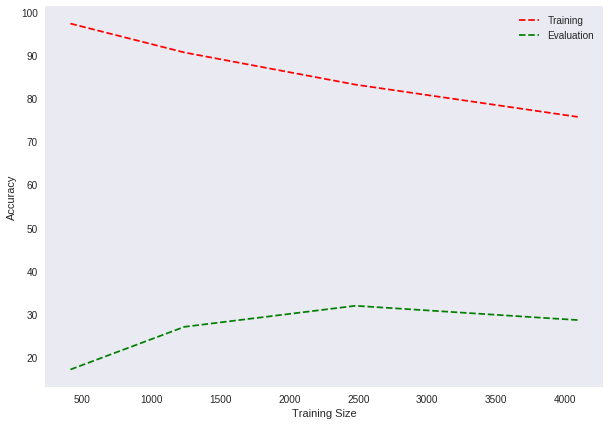

In [310]:
result_2 = modeller(mbn, data_percent)
plot(result_2)

Training & Evaluation Size: 413 | 3719
Training & Evaluation Accuracy: 0.0% | 0.13% 

Training & Evaluation Size: 1239 | 2893
Training & Evaluation Accuracy: 3.79% | 11.41% 

Training & Evaluation Size: 2479 | 1653
Training & Evaluation Accuracy: 7.87% | 15.43% 

Training & Evaluation Size: 4090 | 42
Training & Evaluation Accuracy: 10.78% | 23.81% 



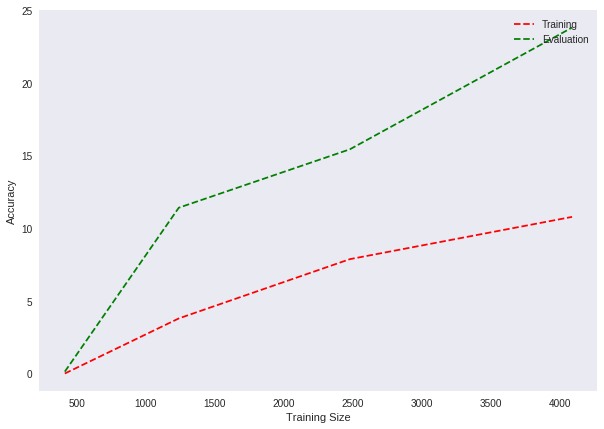

In [311]:
result_3 = modeller(gda, data_percent)
plot(result_3)

### Conclusion

Having observed the variations in the max_features parameter of the countvectorizer i.e (10, 50, 100, 500), there is high disparity in performance of each models as the number of bags words seems to captures the representation of the data. However, on average benchmarking of each model (trade-off in bias and variance), the max_feature = 100 seems to give a more reliable results compared to others. On this model parameter, the GaussianDiscriminantAnalysis resulted in the worst performance and the MultinomialNaiveBayes had a justifiable results for each percentage data variation.